In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno

plt.rcParams["figure.figsize"] = (20, 10)
pd.set_option('display.max_columns', None)


In [2]:
#get unique dictionary of team to franchise IDs to merge into following dataframes
teams = pd.read_csv('LahmanData2023\core\Teams.csv')

franch_IDs = []
for team in teams['teamID'].unique():
    franch_IDs.append(teams[teams['teamID'] == team]['franchID'].iloc(0)[0])

franchises = pd.DataFrame(list(zip(teams['teamID'].unique(),franch_IDs)), columns=['teamID','franchID'])

#case sensitive fix for some differences in formatting :(
warbat = pd.read_csv('war_daily_bat.txt')
warbat = warbat[warbat['year_ID'] > 1984]
for a in warbat['team_ID'].unique():
    if not a in list(franchises['teamID']):
        if a in list(franchises['franchID']):
            franchises.loc[len(franchises.index)] = [a,a]
        else:
            franchises.loc[len(franchises.index)] = ['TBR','TBD']



salary = pd.read_csv('LahmanData2023\contrib\Salaries.csv').merge(franchises, on='teamID')
war_batting = pd.read_csv('war_daily_bat.txt').merge(franchises, left_on='team_ID',right_on='teamID')
war_pitching = pd.read_csv('war_daily_pitch.txt').merge(franchises, left_on='team_ID',right_on='teamID')

In [3]:
# team_salary_lahman = salary.groupby(['yearID','franchID']).agg(sum).reset_index()
# team_salary_bref_batting = war_batting.groupby(['year_ID','franchID']).agg(sum).reset_index().loc[:,['year_ID','franchID','salary']]
# team_salary_bref_pitching = war_pitching.groupby(['year_ID','franchID']).agg(sum).reset_index().loc[:,['year_ID','franchID','salary']]
# team_salary_concat = team_salary_bref_pitching.merge(team_salary_bref_batting, on = ['year_ID','franchID'])
# team_salary_concat['diff'] = team_salary_concat['salary_x'] - team_salary_concat['salary_y']
# team_salary_concat['percent_diff'] = team_salary_concat['salary_x']/team_salary_concat['salary_y']

In [4]:
player_stats_full = war_batting.merge(war_pitching, how='left', on=['player_ID','year_ID','franchID'])
player_stats_full = player_stats_full[player_stats_full['year_ID'] > 1984]
player_stats_full = player_stats_full[player_stats_full['year_ID'] != 1994]
player_stats_full = player_stats_full[player_stats_full['year_ID'] < 2020]
player_stats_full.reset_index(inplace=True)

# summing pitching and batting WAR to create WAR_total column
WAR_total = []
for i in range(len(player_stats_full)):
    x = player_stats_full['WAR_x'][i]
    y = player_stats_full['WAR_y'][i]

    x_true = pd.isna(player_stats_full['WAR_x'][i])
    y_true = pd.isna(player_stats_full['WAR_y'][i])

    if not(x_true or y_true):
        war = x + y
    elif x_true and not y_true:
        war = y
    elif y_true and not x_true:
        war = x
    else:
        war = np.NaN
    
    WAR_total.append(war)

player_stats_full['WAR_total'] = WAR_total

In [8]:
team_salary_bref_batting = war_batting.groupby(['year_ID','franchID']).agg(sum).reset_index().loc[:,['year_ID','franchID','salary','WAR']]
team_stats_full = team_salary_bref_batting.merge(teams, left_on=['year_ID','franchID'], right_on=['yearID','franchID'])

playoffs = []
for i in range(len(team_stats_full)):
    if team_stats_full['WCWin'][i] == 'Y' or team_stats_full['DivWin'][i] == 'Y':
        playoffs.append('Y')
    else:
        playoffs.append('N')

team_stats_full['playoffs'] = playoffs

#removing years with incomplete salary statistics, and 1994 which was an incomplete season due to MLB strike
team_stats_full = team_stats_full[team_stats_full['yearID'] > 1984]
team_stats_full = team_stats_full[team_stats_full['yearID'] != 1994]
team_stats_full = team_stats_full[team_stats_full['yearID'] < 2020]
team_stats_full.reset_index(inplace=True)

#adding a column of salary/yearAverageSalary for each team
yearly_average = team_stats_full.groupby('yearID').agg(['mean',np.std]).reset_index().loc[:,['yearID','salary']]
pct_yearly_average = []
for i in range(len(team_stats_full)):
    pct_yearly_average.append(team_stats_full['salary'][i]/float(yearly_average[yearly_average['yearID'] == team_stats_full['yearID'][i]]['salary']['mean']))

team_stats_full['salary_plus'] = pct_yearly_average

In [40]:
player_stats_full.keys()

Index(['index', 'name_common_x', 'age_x', 'mlb_ID_x', 'player_ID', 'year_ID',
       'team_ID_x', 'stint_ID_x', 'lg_ID_x', 'PA', 'G_x', 'Inn', 'runs_bat',
       'runs_br', 'runs_dp', 'runs_field', 'runs_infield', 'runs_outfield',
       'runs_catcher', 'runs_good_plays', 'runs_defense', 'runs_position',
       'runs_position_p', 'runs_replacement', 'runs_above_rep_x',
       'runs_above_avg_x', 'runs_above_avg_off', 'runs_above_avg_def', 'WAA_x',
       'WAA_off', 'WAA_def', 'WAR_x', 'WAR_def', 'WAR_off', 'WAR_rep_x',
       'salary_x', 'pitcher', 'teamRpG_x', 'oppRpG_x', 'oppRpPA_rep',
       'oppRpG_rep_x', 'pyth_exponent_x', 'pyth_exponent_rep_x',
       'waa_win_perc_x', 'waa_win_perc_off', 'waa_win_perc_def',
       'waa_win_perc_rep_x', 'OPS_plus', 'TOB_lg', 'TB_lg', 'teamID_x',
       'franchID', 'name_common_y', 'age_y', 'mlb_ID_y', 'team_ID_y',
       'stint_ID_y', 'lg_ID_y', 'G_y', 'GS', 'IPouts', 'IPouts_start',
       'IPouts_relief', 'RA', 'xRA', 'xRA_sprp_adj', 'xRA_extr

In [55]:
player_stats_full['WAR_per_salary'] = (player_stats_full['WAR_total']* 1000000)/player_stats_full['salary_x']

In [114]:
season = []
first_season = {}

for i in range(len(player_stats_full)):
    ID = player_stats_full['player_ID'][i]
    if ID in first_season.keys():
        s = player_stats_full['year_ID'][i] - first_season[ID] + 1
    else:
        first_year = min(player_stats_full[player_stats_full['player_ID'] == ID]['year_ID'])
        first_season[ID] = first_year
        s = player_stats_full['year_ID'][i] - first_year + 1
    season.append(s)

player_stats_full['season'] = season

In [115]:
season[:5]

[1, 10, 7, 8, 1]

In [110]:
player_stats_full.head(5)

,index,name_common_x,age_x,mlb_ID_x,player_ID,year_ID,team_ID_x,stint_ID_x,lg_ID_x,PA,G_x,Inn,runs_bat,runs_br,runs_dp,runs_field,runs_infield,runs_outfield,runs_catcher,runs_good_plays,runs_defense,runs_position,runs_position_p,runs_replacement,runs_above_rep_x,runs_above_avg_x,runs_above_avg_off,runs_above_avg_def,WAA_x,WAA_off,WAA_def,WAR_x,WAR_def,WAR_off,WAR_rep_x,salary_x,pitcher,teamRpG_x,oppRpG_x,oppRpPA_rep,oppRpG_rep_x,pyth_exponent_x,pyth_exponent_rep_x,waa_win_perc_x,waa_win_perc_off,waa_win_perc_def,waa_win_perc_rep_x,OPS_plus,TOB_lg,TB_lg,teamID_x,franchID,name_common_y,age_y,mlb_ID_y,team_ID_y,stint_ID_y,lg_ID_y,G_y,GS,IPouts,IPouts_start,IPouts_relief,RA,xRA,xRA_sprp_adj,xRA_extras_adj,xRA_def_pitcher,PPF,PPF_custom,xRA_final,BIP,BIP_perc,RS_def_total,runs_above_avg_y,runs_above_avg_adj,runs_above_rep_y,RpO_replacement,GR_leverage_index_avg,WAR_y,salary_y,teamRpG_y,oppRpG_y,pyth_exponent_y,waa_win_perc_y,WAA_y,WAA_adj,oppRpG_rep_y,pyth_exponent_rep_y,waa_win_perc_rep_y,WAR_rep_y,ERA_plus,ER_lg,teamID_y,WAR_total,WAR_per_salary
0,0,David Aardsma,22.0,430911.0,aardsda01,2004,SFG,1,NL,0.0,11,10.7,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,-0.01,0.00,-0.01,0.00,0.00,300000.0,Y,4.67092,4.67092,0.08651,4.67092,1.890,1.890,0.5000,0.5000,0.5000,0.5000,NaN,0.000,0.000,SFG,SFG,David Aardsma,22.0,430911.0,SFG,1.0,NL,11.0,0.0,32.0,0.0,32.0,8.0,5.967,-0.440,NaN,-0.423,101.0,98.525,5.862,44.0,0.0093,-45.5,-2.138,-2.177,-1.199,0.203,1.0718,-0.15,300000.0,4.67092,4.86883,1.902,0.4803,-0.2167,-0.0298,4.75633,1.895,0.4914,0.0942,66.675000,5.334,SFG,-0.15,-0.500000
1,1,Fernando Abad,33.0,472551.0,abadfe01,2019,SFG,1,NL,0.0,18,13.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,-0.02,0.00,-0.02,0.00,0.00,100000.0,Y,4.72014,4.72014,0.08805,4.72014,1.896,1.896,0.5000,0.5000,0.5000,0.5000,NaN,0.000,0.000,SFG,SFG,Fernando Abad,33.0,472551.0,SFG,1.0,NL,21.0,0.0,39.0,0.0,39.0,6.0,7.327,-0.497,NaN,0.232,95.0,96.286,6.353,37.0,0.0086,27.0,0.353,0.544,1.564,0.207,1.7757,0.17,100000.0,4.72014,4.69424,1.895,0.5026,0.0546,-0.0058,4.77870,1.899,0.4941,0.1201,103.333333,6.200,SFG,0.17,1.700000
2,2,Tony Abreu,28.0,473234.0,abreuto01,2013,SFG,1,NL,147.0,53,251.3,0.87,-1.31,-0.03,-5.0,-1.0,0.0,0.0,1.0,-5.0,1.02,0.00,4.78,0.3,-4.5,0.6,-4.0,-0.53,0.03,-0.48,-0.06,-0.48,0.50,0.47,498000.0,N,4.03838,4.02801,0.07154,3.93786,1.813,1.807,0.4906,0.5012,0.4916,0.4898,110.055734,45.771,53.544,SFG,SFG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.06,-0.120482
3,3,Tony Abreu,29.0,473234.0,abreuto01,2014,SFG,1,NL,4.0,3,6.7,-0.98,0.00,-0.19,0.0,0.0,0.0,0.0,0.0,0.0,0.03,0.00,0.13,-1.0,-1.1,-1.1,0.0,-0.13,-0.13,0.00,-0.12,0.00,-0.12,0.01,745000.0,N,3.61035,3.99035,0.07088,3.94701,1.783,1.805,0.4555,0.4555,0.5011,0.4951,-100.000000,1.254,1.546,SFG,SFG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.12,-0.161074
4,4,Jeremy Accardo,23.0,435618.0,accarje01,2005,SFG,1,NL,2.0,28,29.7,0.10,-0.16,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.28,0.00,0.2,0.2,0.2,0.0,0.02,0.02,-0.01,0.02,-0.01,0.02,0.00,NaN,Y,4.56122,4.55336,0.08379,4.55114,1.877,1.877,0.5008,0.5008,0.5000,0.4998,163.473259,0.680,0.859,SFG,SFG,Jeremy Accardo,23.0,435618.0,SFG,1.0,NL,28.0,0.0,89.0,0.0,89.0,13.0,15.354,-1.170,NaN,-0.559,101.0,99.306,14.641,98.0,0.0210,-26.6,1.641,1.633,4.187,0.198,1.2832,0.39,NaN,4.55336,4.49504,1.873,0.5060,0.1680,-0.0442,4.64468,1.882,0.4907,0.2616,109.623077,14.251,SFG,0.41,NaN


In [112]:
player_stats_full[player_stats_full['player_ID'] == 'abadfe01']

,index,name_common_x,age_x,mlb_ID_x,player_ID,year_ID,team_ID_x,stint_ID_x,lg_ID_x,PA,G_x,Inn,runs_bat,runs_br,runs_dp,runs_field,runs_infield,runs_outfield,runs_catcher,runs_good_plays,runs_defense,runs_position,runs_position_p,runs_replacement,runs_above_rep_x,runs_above_avg_x,runs_above_avg_off,runs_above_avg_def,WAA_x,WAA_off,WAA_def,WAR_x,WAR_def,WAR_off,WAR_rep_x,salary_x,pitcher,teamRpG_x,oppRpG_x,oppRpPA_rep,oppRpG_rep_x,pyth_exponent_x,pyth_exponent_rep_x,waa_win_perc_x,waa_win_perc_off,waa_win_perc_def,waa_win_perc_rep_x,OPS_plus,TOB_lg,TB_lg,teamID_x,franchID,name_common_y,age_y,mlb_ID_y,team_ID_y,stint_ID_y,lg_ID_y,G_y,GS,IPouts,IPouts_start,IPouts_relief,RA,xRA,xRA_sprp_adj,xRA_extras_adj,xRA_def_pitcher,PPF,PPF_custom,xRA_final,BIP,BIP_perc,RS_def_total,runs_above_avg_y,runs_above_avg_adj,runs_above_rep_y,RpO_replacement,GR_leverage_index_avg,WAR_y,salary_y,teamRpG_y,oppRpG_y,pyth_exponent_y,waa_win_perc_y,WAA_y,WAA_adj,oppRpG_rep_y,pyth_exponent_rep_y,waa_win_perc_rep_y,WAR_rep_y,ERA_plus,ER_lg,teamID_y,WAR_total,WAR_per_salary
1,1,Fernando Abad,33.0,472551.0,abadfe01,2019,SFG,1,NL,0.0,18,13.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,-0.02,0.00,-0.02,0.00,0.0,100000.0,Y,4.72014,4.72014,0.08805,4.72014,1.896,1.896,0.5000,0.5000,0.5,0.5000,NaN,0.000,0.000,SFG,SFG,Fernando Abad,33.0,472551.0,SFG,1.0,NL,21.0,0.0,39.0,0.0,39.0,6.0,7.327,-0.497,NaN,0.232,95.0,96.286,6.353,37.0,0.0086,27.0,0.353,0.544,1.564,0.207,1.7757,0.17,100000.0,4.72014,4.69424,1.895,0.5026,0.0546,-0.0058,4.77870,1.899,0.4941,0.1201,103.333333,6.200,SFG,0.17,1.700000
4450,12352,Fernando Abad,30.0,472551.0,abadfe01,2016,BOS,2,AL,0.0,2,12.7,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,1250000.0,Y,4.50306,4.50306,0.07941,4.50306,1.871,1.871,0.5000,0.5000,0.5,0.5000,NaN,0.000,0.000,BOS,BOS,Fernando Abad,30.0,472551.0,BOS,2.0,AL,18.0,0.0,38.0,0.0,38.0,9.0,6.788,-0.490,NaN,0.649,106.0,104.567,5.907,39.0,0.0094,69.0,-3.093,-3.087,-1.840,0.200,1.3778,-0.28,1250000.0,4.50306,4.67456,1.881,0.4824,-0.3168,-0.0899,4.57188,1.875,0.4929,0.1294,71.633333,6.447,BOS,-0.28,-0.224000
4451,12353,Fernando Abad,31.0,472551.0,abadfe01,2017,BOS,1,AL,0.0,4,43.7,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,2000000.0,Y,4.69540,4.69540,0.08396,4.69540,1.893,1.893,0.5000,0.5000,0.5,0.5000,NaN,0.000,0.000,BOS,BOS,Fernando Abad,31.0,472551.0,BOS,1.0,AL,48.0,0.0,131.0,0.0,131.0,18.0,23.256,-1.623,NaN,2.583,104.0,105.110,20.023,130.0,0.0315,82.0,2.023,1.858,6.528,0.209,0.6794,0.47,2000000.0,4.69540,4.65669,1.891,0.5039,0.1872,-0.1585,4.78941,1.899,0.4906,0.4446,139.062500,22.250,BOS,0.47,0.235000
17248,38140,Fernando Abad,28.0,472551.0,abadfe01,2014,OAK,1,AL,0.0,7,57.3,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.01,0.00,0.01,0.00,0.0,525900.0,Y,4.13265,4.13265,0.07083,4.13265,1.826,1.826,0.5000,0.5000,0.5,0.5000,NaN,0.000,0.000,OAK,OAK,Fernando Abad,28.0,472551.0,OAK,1.0,AL,69.0,0.0,172.0,0.0,172.0,11.0,26.563,-1.979,NaN,0.923,97.0,96.861,22.918,146.0,0.0342,27.0,11.918,11.218,17.124,0.184,1.1510,1.79,525900.0,4.13265,3.97007,1.815,0.5182,1.2558,-0.0513,4.20835,1.830,0.4917,0.5814,237.710000,23.771,OAK,1.79,3.403689
17249,38141,Fernando Abad,29.0,472551.0,abadfe01,2015,OAK,1,AL,0.0,4,47.7,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,1087500.0,Y,4.30400,4.30400,0.07510,4.30400,1.847,1.847,0.5000,0.5000,0.5,0.5000,NaN,0.000,0.000,OAK,OAK,Fernando Abad,29.0,472551.0,OAK,1.0,AL,62.0,0.0,143.0,0.0,143.0,23.0,23.790,-1.758,NaN,-0.506,97.0,95.668,21.562,140.0,0.0316,-16.0,-1.438,-2.116,3.069,0.192,0.7174,0.18,1087500.0,4.30400,4.33813,1.849,0.4963,-0.2294,-0.0785,4.37781,1.851,0.4921,0.4883,94.472727,20.784,OAK,0.18,0.165517
20316,45556,Fernando Abad,24.0,472551.0,abadfe01,2010,HOU,1,NL,1.0,22,19.0,-0.27,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.13,

In [42]:
player_stats_full.head()

,index,name_common_x,age_x,mlb_ID_x,player_ID,year_ID,team_ID_x,stint_ID_x,lg_ID_x,PA,G_x,Inn,runs_bat,runs_br,runs_dp,runs_field,runs_infield,runs_outfield,runs_catcher,runs_good_plays,runs_defense,runs_position,runs_position_p,runs_replacement,runs_above_rep_x,runs_above_avg_x,runs_above_avg_off,runs_above_avg_def,WAA_x,WAA_off,WAA_def,WAR_x,WAR_def,WAR_off,WAR_rep_x,salary_x,pitcher,teamRpG_x,oppRpG_x,oppRpPA_rep,oppRpG_rep_x,pyth_exponent_x,pyth_exponent_rep_x,waa_win_perc_x,waa_win_perc_off,waa_win_perc_def,waa_win_perc_rep_x,OPS_plus,TOB_lg,TB_lg,teamID_x,franchID,name_common_y,age_y,mlb_ID_y,team_ID_y,stint_ID_y,lg_ID_y,G_y,GS,IPouts,IPouts_start,IPouts_relief,RA,xRA,xRA_sprp_adj,xRA_extras_adj,xRA_def_pitcher,PPF,PPF_custom,xRA_final,BIP,BIP_perc,RS_def_total,runs_above_avg_y,runs_above_avg_adj,runs_above_rep_y,RpO_replacement,GR_leverage_index_avg,WAR_y,salary_y,teamRpG_y,oppRpG_y,pyth_exponent_y,waa_win_perc_y,WAA_y,WAA_adj,oppRpG_rep_y,pyth_exponent_rep_y,waa_win_perc_rep_y,WAR_rep_y,ERA_plus,ER_lg,teamID_y,WAR_total,WAR_per_salary
0,0,David Aardsma,22.0,430911.0,aardsda01,2004,SFG,1,NL,0.0,11,10.7,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,-0.01,0.00,-0.01,0.00,0.00,300000.0,Y,4.67092,4.67092,0.08651,4.67092,1.890,1.890,0.5000,0.5000,0.5000,0.5000,NaN,0.000,0.000,SFG,SFG,David Aardsma,22.0,430911.0,SFG,1.0,NL,11.0,0.0,32.0,0.0,32.0,8.0,5.967,-0.440,NaN,-0.423,101.0,98.525,5.862,44.0,0.0093,-45.5,-2.138,-2.177,-1.199,0.203,1.0718,-0.15,300000.0,4.67092,4.86883,1.902,0.4803,-0.2167,-0.0298,4.75633,1.895,0.4914,0.0942,66.675000,5.334,SFG,-0.15,-5.000000e-07
1,1,Fernando Abad,33.0,472551.0,abadfe01,2019,SFG,1,NL,0.0,18,13.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,-0.02,0.00,-0.02,0.00,0.00,100000.0,Y,4.72014,4.72014,0.08805,4.72014,1.896,1.896,0.5000,0.5000,0.5000,0.5000,NaN,0.000,0.000,SFG,SFG,Fernando Abad,33.0,472551.0,SFG,1.0,NL,21.0,0.0,39.0,0.0,39.0,6.0,7.327,-0.497,NaN,0.232,95.0,96.286,6.353,37.0,0.0086,27.0,0.353,0.544,1.564,0.207,1.7757,0.17,100000.0,4.72014,4.69424,1.895,0.5026,0.0546,-0.0058,4.77870,1.899,0.4941,0.1201,103.333333,6.200,SFG,0.17,1.700000e-06
2,2,Tony Abreu,28.0,473234.0,abreuto01,2013,SFG,1,NL,147.0,53,251.3,0.87,-1.31,-0.03,-5.0,-1.0,0.0,0.0,1.0,-5.0,1.02,0.00,4.78,0.3,-4.5,0.6,-4.0,-0.53,0.03,-0.48,-0.06,-0.48,0.50,0.47,498000.0,N,4.03838,4.02801,0.07154,3.93786,1.813,1.807,0.4906,0.5012,0.4916,0.4898,110.055734,45.771,53.544,SFG,SFG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.06,-1.204819e-07
3,3,Tony Abreu,29.0,473234.0,abreuto01,2014,SFG,1,NL,4.0,3,6.7,-0.98,0.00,-0.19,0.0,0.0,0.0,0.0,0.0,0.0,0.03,0.00,0.13,-1.0,-1.1,-1.1,0.0,-0.13,-0.13,0.00,-0.12,0.00,-0.12,0.01,745000.0,N,3.61035,3.99035,0.07088,3.94701,1.783,1.805,0.4555,0.4555,0.5011,0.4951,-100.000000,1.254,1.546,SFG,SFG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.12,-1.610738e-07
4,4,Jeremy Accardo,23.0,435618.0,accarje01,2005,SFG,1,NL,2.0,28,29.7,0.10,-0.16,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.28,0.00,0.2,0.2,0.2,0.0,0.02,0.02,-0.01,0.02,-0.01,0.02,0.00,NaN,Y,4.56122,4.55336,0.08379,4.55114,1.877,1.877,0.5008,0.5008,0.5000,0.4998,163.473259,0.680,0.859,SFG,SFG,Jeremy Accardo,23.0,435618.0,SFG,1.0,NL,28.0,0.0,89.0,0.0,89.0,13.0,15.354,-1.170,NaN,-0.559,101.0,99.306,14.641,98.0,0.0210,-26.6,1.641,1.633,4.187,0.198,1.2832,0.39,NaN,4.55336,4.49504,1.873,0.5060,0.1680,-0.0442,4.64468,1.882,0.4907,0.2616,109.623077,14.251,SFG,0.41,NaN


In [47]:
player_stats_full.describe()['salary_x']

count    2.794500e+04
mean     2.311621e+06
std      3.855937e+06
min      0.000000e+00
25%      3.185000e+05
50%      6.000000e+05
75%      2.525000e+06
max      3.833333e+07
Name: salary_x, dtype: float64

In [69]:
player_stats_full[player_stats_full['salary_x'].isnull()].sort_values('WAR_total', ascending=False)

,index,name_common_x,age_x,mlb_ID_x,player_ID,year_ID,team_ID_x,stint_ID_x,lg_ID_x,PA,G_x,Inn,runs_bat,runs_br,runs_dp,runs_field,runs_infield,runs_outfield,runs_catcher,runs_good_plays,runs_defense,runs_position,runs_position_p,runs_replacement,runs_above_rep_x,runs_above_avg_x,runs_above_avg_off,runs_above_avg_def,WAA_x,WAA_off,WAA_def,WAR_x,WAR_def,WAR_off,WAR_rep_x,salary_x,pitcher,teamRpG_x,oppRpG_x,oppRpPA_rep,oppRpG_rep_x,pyth_exponent_x,pyth_exponent_rep_x,waa_win_perc_x,waa_win_perc_off,waa_win_perc_def,waa_win_perc_rep_x,OPS_plus,TOB_lg,TB_lg,teamID_x,franchID,name_common_y,age_y,mlb_ID_y,team_ID_y,stint_ID_y,lg_ID_y,G_y,GS,IPouts,IPouts_start,IPouts_relief,RA,xRA,xRA_sprp_adj,xRA_extras_adj,xRA_def_pitcher,PPF,PPF_custom,xRA_final,BIP,BIP_perc,RS_def_total,runs_above_avg_y,runs_above_avg_adj,runs_above_rep_y,RpO_replacement,GR_leverage_index_avg,WAR_y,salary_y,teamRpG_y,oppRpG_y,pyth_exponent_y,waa_win_perc_y,WAA_y,WAA_adj,oppRpG_rep_y,pyth_exponent_rep_y,waa_win_perc_rep_y,WAR_rep_y,ERA_plus,ER_lg,teamID_y,WAR_total,WAR_per_salary
39355,93522,Blake Snell,25.0,605483.0,snellbl01,2018,TBR,1,AL,3.0,1,180.7,0.38,-0.01,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.46,0.00,0.8,0.8,0.8,0.0,0.08,0.08,0.00,0.08,0.00,0.08,0.00,NaN,Y,5.41865,4.57865,0.08136,4.47116,1.927,1.873,0.5804,0.5804,0.5010,0.4889,111.864407,0.944,0.411,TBR,TBD,Blake Snell,25.0,605483.0,TBR,1.0,AL,31.0,31.0,542.0,542.0,0.0,41.0,94.493,4.214,NaN,5.774,96.0,95.54,88.788,414.0,0.1031,56.0,47.788,47.703,65.962,0.204,1.0,7.08,NaN,4.57865,3.03984,1.784,0.675,5.425,-0.1108,5.16943,1.914,0.4422,1.763,216.997368,82.459,TBR,7.16,NaN
2666,6687,Ryne Sandberg,31.0,121665.0,sandbry01,1991,CHC,1,NL,684.0,158,1374.7,32.72,2.54,0.72,8.5,-3.0,0.0,0.0,NaN,5.5,4.57,0.00,21.38,67.4,46.1,40.6,10.1,4.90,4.21,1.10,7.03,1.10,6.34,2.13,NaN,N,4.35782,4.10117,0.07367,3.96587,1.838,1.813,0.5317,0.5279,0.5071,0.4848,138.361215,225.732,229.730,CHC,CHC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.03,NaN
6543,17780,Mitch Haniger,27.0,571745.0,hanigmi01,2018,SEA,1,AL,683.0,157,1385.7,34.83,0.17,0.52,0.0,0.0,5.0,0.0,3.0,8.0,-5.06,0.00,23.94,62.4,38.5,30.5,2.9,4.21,3.22,0.52,6.48,0.52,5.49,2.27,NaN,N,4.77266,4.57865,0.08136,4.42616,1.891,1.871,0.5249,0.5196,0.5019,0.4842,139.442331,212.345,241.559,SEA,SEA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.48,NaN
40917,95524,Devon White,28.0,124164.0,whitede03,1991,TOR,1,AL,715.0,156,1384.0,13.25,3.05,1.08,16.8,0.0,1.0,0.0,NaN,17.8,3.13,0.00,23.91,62.2,38.3,20.5,20.9,4.10,2.29,2.23,6.34,2.23,4.53,2.24,NaN,N,4.60683,4.47535,0.07770,4.32211,1.875,1.858,0.5256,0.5136,0.5141,0.4838,115.697245,237.140,257.891,TOR,TOR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.34,NaN
33144,81446,Tommy Pham,29.0,502054.0,phamth01,2017,STL,1,NL,530.0,128,1026.7,35.62,2.99,-1.23,6.0,0.0,5.0,0.0,1.0,12.0,-2.48,0.00,17.23,64.1,46.9,34.9,9.5,4.57,3.38,0.92,6.24,0.92,5.05,1.67,NaN,N,4.93389,4.66123,0.08583,4.52666,1.905,1.882,0.5366,0.5270,0.5076,0.4862,144.274003,174.715,192.385,STL,STL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.24,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43055,98865,Eric Bullock,32.0,111685.0,bulloer01,1992,MON,1,NL,5.0,8,0.0,

In [92]:
min_sal_yearly = []
for year in player_stats_full.sort_values('year_ID')['year_ID'].unique():
    min_sal_yearly.append(min(player_stats_full[(player_stats_full['salary_x'] > 1000) & (player_stats_full['year_ID'] == year) & (player_stats_full['G_x'] > 90)]['salary_x']))

min_sal_yearly

[60000.0,
 60000.0,
 62500.0,
 62500.0,
 68000.0,
 100000.0,
 100000.0,
 109000.0,
 109000.0,
 109000.0,
 109000.0,
 109500.0,
 170000.0,
 200000.0,
 200000.0,
 200000.0,
 200000.0,
 300000.0,
 300000.0,
 300000.0,
 327000.0,
 380000.0,
 390000.0,
 400000.0,
 400000.0,
 414000.0,
 480000.0,
 490000.0,
 500000.0,
 507500.0,
 507500.0,
 535000.0,
 545000.0,
 100000.0]

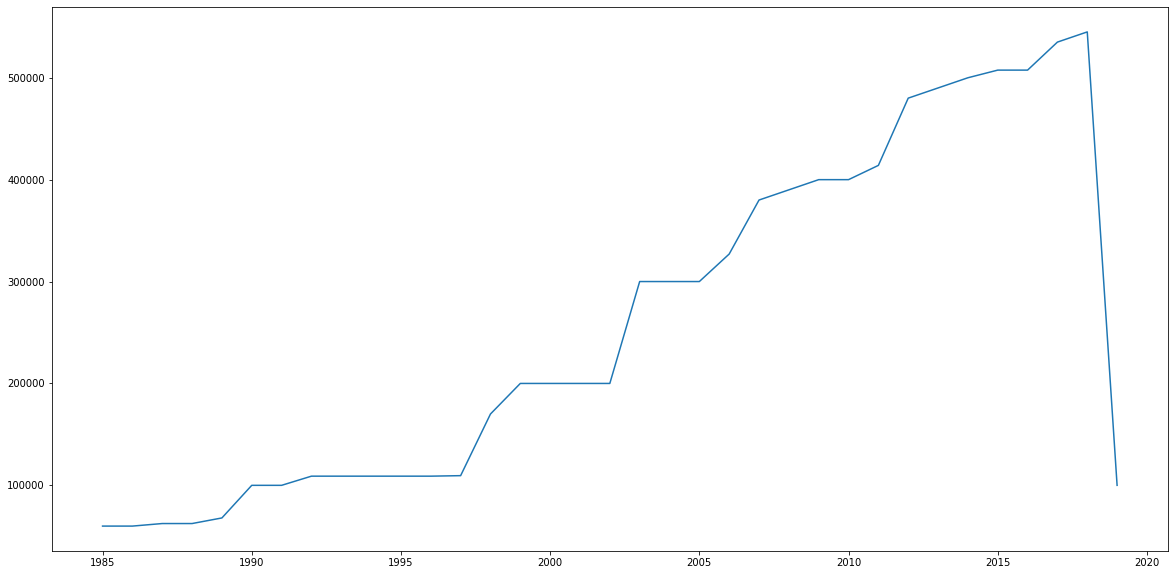

In [93]:
plt.plot(player_stats_full.sort_values('year_ID')['year_ID'].unique(), min_sal_yearly)

In [79]:
min(player_stats_full[player_stats_full['salary_x'] > 1000]['salary_x'])

60000.0

In [100]:
player_stats_full[(player_stats_full['salary_x'].isnull()) & (player_stats_full['year_ID'] == 2017)].sort_values('WAR_total', ascending=False)

,index,name_common_x,age_x,mlb_ID_x,player_ID,year_ID,team_ID_x,stint_ID_x,lg_ID_x,PA,G_x,Inn,runs_bat,runs_br,runs_dp,runs_field,runs_infield,runs_outfield,runs_catcher,runs_good_plays,runs_defense,runs_position,runs_position_p,runs_replacement,runs_above_rep_x,runs_above_avg_x,runs_above_avg_off,runs_above_avg_def,WAA_x,WAA_off,WAA_def,WAR_x,WAR_def,WAR_off,WAR_rep_x,salary_x,pitcher,teamRpG_x,oppRpG_x,oppRpPA_rep,oppRpG_rep_x,pyth_exponent_x,pyth_exponent_rep_x,waa_win_perc_x,waa_win_perc_off,waa_win_perc_def,waa_win_perc_rep_x,OPS_plus,TOB_lg,TB_lg,teamID_x,franchID,name_common_y,age_y,mlb_ID_y,team_ID_y,stint_ID_y,lg_ID_y,G_y,GS,IPouts,IPouts_start,IPouts_relief,RA,xRA,xRA_sprp_adj,xRA_extras_adj,xRA_def_pitcher,PPF,PPF_custom,xRA_final,BIP,BIP_perc,RS_def_total,runs_above_avg_y,runs_above_avg_adj,runs_above_rep_y,RpO_replacement,GR_leverage_index_avg,WAR_y,salary_y,teamRpG_y,oppRpG_y,pyth_exponent_y,waa_win_perc_y,WAA_y,WAA_adj,oppRpG_rep_y,pyth_exponent_rep_y,waa_win_perc_rep_y,WAR_rep_y,ERA_plus,ER_lg,teamID_y,WAR_total,WAR_per_salary
33144,81446,Tommy Pham,29.0,502054.0,phamth01,2017,STL,1,NL,530.0,128,1026.7,35.62,2.99,-1.23,6.0,0.0,5.0,0.0,1.0,12.0,-2.48,0.00,17.23,64.1,46.9,34.9,9.5,4.57,3.38,0.92,6.24,0.92,5.05,1.67,NaN,N,4.93389,4.66123,0.08583,4.52666,1.905,1.882,0.5366,0.5270,0.5076,0.4862,144.274003,174.715,192.385,STL,STL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.24,NaN
29937,74961,Justin Upton,29.0,457708.0,uptonju01,2017,DET,1,AL,520.0,125,1058.7,24.91,0.12,0.87,13.0,0.0,-2.0,0.0,1.0,12.0,-4.55,0.00,18.63,52.0,33.4,21.4,7.5,3.40,2.19,0.82,5.20,0.82,3.99,1.80,NaN,N,4.86620,4.69540,0.08396,4.54634,1.903,1.885,0.5267,0.5170,0.5061,0.4848,136.602660,169.416,198.196,DET,DET,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.20,NaN
29970,75015,Justin Verlander,34.0,434378.0,verlaju01,2017,DET,1,AL,6.0,2,172.0,-0.94,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.93,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,Y,4.69540,4.69540,0.08396,4.58791,1.893,1.887,0.5000,0.5000,0.5005,0.4891,-10.253968,1.955,2.591,DET,DET,Justin Verlander,34.0,434378.0,DET,1.0,AL,28.0,28.0,516.0,510.0,6.0,76.0,90.791,3.758,NaN,-10.525,102.0,103.893,109.165,483.0,0.1074,-98.0,33.165,32.515,50.908,0.209,1.000,5.11,NaN,4.69540,3.53415,1.823,0.6267,3.5476,-0.1208,5.33026,1.929,0.4391,1.6791,117.082192,85.470,DET,5.11,NaN
17063,37818,Chris Taylor,26.0,621035.0,tayloch03,2017,LAD,1,NL,568.0,140,1102.0,19.79,3.41,1.28,0.0,0.0,3.0,0.0,-1.0,2.0,0.81,0.00,18.46,45.8,27.3,25.3,2.8,2.61,2.45,0.22,4.40,0.22,4.24,1.79,NaN,N,4.84187,4.66123,0.08583,4.52937,1.900,1.882,0.5195,0.5181,0.5020,0.4865,123.357383,186.418,220.712,LAD,LAD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.40,NaN
15804,35611,Cody Bellinger,21.0,641355.0,bellico01,2017,LAD,1,NL,548.0,132,1124.0,24.19,0.08,1.50,6.0,-1.0,-1.0,0.0,0.0,4.0,-6.99,0.00,17.81,40.6,22.8,18.8,-3.0,2.17,1.81,-0.35,3.89,-0.35,3.53,1.72,NaN,N,4.80350,4.66123,0.08583,4.52631,1.898,1.882,0.5173,0.5143,0.4977,0.4862,142.672560,179.854,206.112,LAD,LAD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.89,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19269,42146,Amir Garrett,25.0,607237.0,gar

In [104]:
player_stats_full[player_stats_full['player_ID'] == 'gennesc01']

,index,name_common_x,age_x,mlb_ID_x,player_ID,year_ID,team_ID_x,stint_ID_x,lg_ID_x,PA,G_x,Inn,runs_bat,runs_br,runs_dp,runs_field,runs_infield,runs_outfield,runs_catcher,runs_good_plays,runs_defense,runs_position,runs_position_p,runs_replacement,runs_above_rep_x,runs_above_avg_x,runs_above_avg_off,runs_above_avg_def,WAA_x,WAA_off,WAA_def,WAR_x,WAR_def,WAR_off,WAR_rep_x,salary_x,pitcher,teamRpG_x,oppRpG_x,oppRpPA_rep,oppRpG_rep_x,pyth_exponent_x,pyth_exponent_rep_x,waa_win_perc_x,waa_win_perc_off,waa_win_perc_def,waa_win_perc_rep_x,OPS_plus,TOB_lg,TB_lg,teamID_x,franchID,name_common_y,age_y,mlb_ID_y,team_ID_y,stint_ID_y,lg_ID_y,G_y,GS,IPouts,IPouts_start,IPouts_relief,RA,xRA,xRA_sprp_adj,xRA_extras_adj,xRA_def_pitcher,PPF,PPF_custom,xRA_final,BIP,BIP_perc,RS_def_total,runs_above_avg_y,runs_above_avg_adj,runs_above_rep_y,RpO_replacement,GR_leverage_index_avg,WAR_y,salary_y,teamRpG_y,oppRpG_y,pyth_exponent_y,waa_win_perc_y,WAA_y,WAA_adj,oppRpG_rep_y,pyth_exponent_rep_y,waa_win_perc_rep_y,WAR_rep_y,ERA_plus,ER_lg,teamID_y,WAR_total,WAR_per_salary
508,863,Scooter Gennett,29.0,571697.0,gennesc01,2019,SFG,2,NL,67.0,21,133.7,-2.57,0.11,0.61,-1.0,0.0,0.0,0.0,0.0,-1.0,0.42,0.0,2.18,-0.3,-2.4,-1.4,-0.6,-0.27,-0.15,-0.08,-0.06,-0.08,0.06,0.21,NaN,N,4.65205,4.72014,0.08805,4.61645,1.892,1.890,0.4884,0.4931,0.4972,0.4895,68.066400,21.715,27.846,SFG,SFG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.06,NaN
12682,29426,Scooter Gennett,23.0,571697.0,gennesc01,2013,MIL,1,NL,230.0,69,487.7,9.36,0.07,0.55,-4.0,0.0,0.0,0.0,0.0,-4.0,1.51,0.0,7.48,15.0,7.5,11.5,-2.5,0.78,1.24,-0.31,1.52,-0.31,1.98,0.74,NaN,N,4.19453,4.02801,0.07154,3.91967,1.823,1.805,0.5120,0.5185,0.4960,0.4877,126.843478,73.485,86.457,MIL,MIL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.52,NaN
12683,29427,Scooter Gennett,24.0,571697.0,gennesc01,2014,MIL,1,NL,474.0,137,967.0,2.59,0.38,-1.20,-5.0,-2.0,0.0,0.0,0.0,-7.0,2.98,0.0,15.41,13.2,-2.3,4.8,-4.0,-0.41,0.45,-0.56,1.11,-0.56,1.97,1.52,504000.0,N,4.02502,3.99035,0.07088,3.87790,1.810,1.800,0.4982,0.5039,0.4967,0.4871,107.049827,150.937,176.308,MIL,MIL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.11,2.202381
12684,29428,Scooter Gennett,25.0,571697.0,gennesc01,2015,MIL,1,NL,391.0,114,819.0,-9.42,0.55,-1.21,-1.0,-2.0,0.0,0.0,0.0,-3.0,2.58,0.0,12.71,2.2,-10.5,-7.5,-0.4,-1.20,-0.90,-0.07,0.04,-0.07,0.34,1.24,516500.0,N,4.15643,4.22222,0.07613,4.11075,1.833,1.830,0.4900,0.4928,0.4996,0.4878,83.802636,126.723,153.675,MIL,MIL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.04,0.077444
12685,29429,Scooter Gennett,26.0,571697.0,gennesc01,2016,MIL,1,NL,542.0,136,1071.0,-4.61,-0.84,-0.27,-4.0,-2.0,0.0,0.0,-2.0,-8.0,3.31,0.0,17.62,7.2,-10.4,-2.4,-4.7,-1.19,-0.34,-0.54,0.52,-0.54,1.37,1.71,518100.0,N,4.48238,4.50010,0.08241,4.37058,1.869,1.863,0.4921,0.4982,0.4964,0.4864,91.084707,179.712,213.692,MIL,MIL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.52,1.003667
19273,42164,Scooter Gennett,27.0,571697.0,gennesc01,2017,CIN,1,NL,497.0,141,964.6,16.49,-1.52,0.04,-9.0,-2.0,0.0,0.0,-1.0,-12.0,2.01,0.0,16.15,21.2,5.0,17.0,-10.0,0.41,1.64,-1.06,1.96,-1.06,3.19,1.55,NaN,N,4.78194,4.66123,0.08583,4.54668,1.896,1.883,0.5036,0.5121,0.4929,0.4883,123.168322,166.445,202.425,CIN,CIN,Scooter Gennett,27.0,571697.0,CIN,1.0,NL,1.0,0.0,3.0,0.0,3.0,2.0,0.551,-0.039,NaN,0.056,103.0,102.0,0.465,5.0,0.0012,47.0,-1.535,-1.531,-1.443,0.204,0.0,-0.06,NaN,4.66123

In [65]:
sum(war_batting['salary'].isnull())

57014

In [71]:
sum(player_stats_full['salary_x'].isnull())

16177

In [72]:
len(player_stats_full)

44122

In [11]:
player_stats_full.head()

,index,name_common_x,age_x,mlb_ID_x,player_ID,year_ID,team_ID_x,stint_ID_x,lg_ID_x,PA,G_x,Inn,runs_bat,runs_br,runs_dp,runs_field,runs_infield,runs_outfield,runs_catcher,runs_good_plays,runs_defense,runs_position,runs_position_p,runs_replacement,runs_above_rep_x,runs_above_avg_x,runs_above_avg_off,runs_above_avg_def,WAA_x,WAA_off,WAA_def,WAR_x,WAR_def,WAR_off,WAR_rep_x,salary_x,pitcher,teamRpG_x,oppRpG_x,oppRpPA_rep,oppRpG_rep_x,pyth_exponent_x,pyth_exponent_rep_x,waa_win_perc_x,waa_win_perc_off,waa_win_perc_def,waa_win_perc_rep_x,OPS_plus,TOB_lg,TB_lg,teamID_x,franchID,name_common_y,age_y,mlb_ID_y,team_ID_y,stint_ID_y,lg_ID_y,G_y,GS,IPouts,IPouts_start,IPouts_relief,RA,xRA,xRA_sprp_adj,xRA_extras_adj,xRA_def_pitcher,PPF,PPF_custom,xRA_final,BIP,BIP_perc,RS_def_total,runs_above_avg_y,runs_above_avg_adj,runs_above_rep_y,RpO_replacement,GR_leverage_index_avg,WAR_y,salary_y,teamRpG_y,oppRpG_y,pyth_exponent_y,waa_win_perc_y,WAA_y,WAA_adj,oppRpG_rep_y,pyth_exponent_rep_y,waa_win_perc_rep_y,WAR_rep_y,ERA_plus,ER_lg,teamID_y,WAR_total
0,0,David Aardsma,22.0,430911.0,aardsda01,2004,SFG,1,NL,0.0,11,10.7,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,-0.01,0.00,-0.01,0.00,0.00,300000.0,Y,4.67092,4.67092,0.08651,4.67092,1.890,1.890,0.5000,0.5000,0.5000,0.5000,NaN,0.000,0.000,SFG,SFG,David Aardsma,22.0,430911.0,SFG,1.0,NL,11.0,0.0,32.0,0.0,32.0,8.0,5.967,-0.440,NaN,-0.423,101.0,98.525,5.862,44.0,0.0093,-45.5,-2.138,-2.177,-1.199,0.203,1.0718,-0.15,300000.0,4.67092,4.86883,1.902,0.4803,-0.2167,-0.0298,4.75633,1.895,0.4914,0.0942,66.675000,5.334,SFG,-0.15
1,1,Fernando Abad,33.0,472551.0,abadfe01,2019,SFG,1,NL,0.0,18,13.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,-0.02,0.00,-0.02,0.00,0.00,100000.0,Y,4.72014,4.72014,0.08805,4.72014,1.896,1.896,0.5000,0.5000,0.5000,0.5000,NaN,0.000,0.000,SFG,SFG,Fernando Abad,33.0,472551.0,SFG,1.0,NL,21.0,0.0,39.0,0.0,39.0,6.0,7.327,-0.497,NaN,0.232,95.0,96.286,6.353,37.0,0.0086,27.0,0.353,0.544,1.564,0.207,1.7757,0.17,100000.0,4.72014,4.69424,1.895,0.5026,0.0546,-0.0058,4.77870,1.899,0.4941,0.1201,103.333333,6.200,SFG,0.17
2,2,Tony Abreu,28.0,473234.0,abreuto01,2013,SFG,1,NL,147.0,53,251.3,0.87,-1.31,-0.03,-5.0,-1.0,0.0,0.0,1.0,-5.0,1.02,0.00,4.78,0.3,-4.5,0.6,-4.0,-0.53,0.03,-0.48,-0.06,-0.48,0.50,0.47,498000.0,N,4.03838,4.02801,0.07154,3.93786,1.813,1.807,0.4906,0.5012,0.4916,0.4898,110.055734,45.771,53.544,SFG,SFG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.06
3,3,Tony Abreu,29.0,473234.0,abreuto01,2014,SFG,1,NL,4.0,3,6.7,-0.98,0.00,-0.19,0.0,0.0,0.0,0.0,0.0,0.0,0.03,0.00,0.13,-1.0,-1.1,-1.1,0.0,-0.13,-0.13,0.00,-0.12,0.00,-0.12,0.01,745000.0,N,3.61035,3.99035,0.07088,3.94701,1.783,1.805,0.4555,0.4555,0.5011,0.4951,-100.000000,1.254,1.546,SFG,SFG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.12
4,4,Jeremy Accardo,23.0,435618.0,accarje01,2005,SFG,1,NL,2.0,28,29.7,0.10,-0.16,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.28,0.00,0.2,0.2,0.2,0.0,0.02,0.02,-0.01,0.02,-0.01,0.02,0.00,NaN,Y,4.56122,4.55336,0.08379,4.55114,1.877,1.877,0.5008,0.5008,0.5000,0.4998,163.473259,0.680,0.859,SFG,SFG,Jeremy Accardo,23.0,435618.0,SFG,1.0,NL,28.0,0.0,89.0,0.0,89.0,13.0,15.354,-1.170,NaN,-0.559,101.0,99.306,14.641,98.0,0.0210,-26.6,1.641,1.633,4.187,0.198,1.2832,0.39,NaN,4.55336,4.49504,1.873,0.5060,0.1680,-0.0442,4.64468,1.882,0.4907,0.2616,109.623077,14.251,SFG,0.41


<AxesSubplot:xlabel='WAR_per_salary', ylabel='Count'>

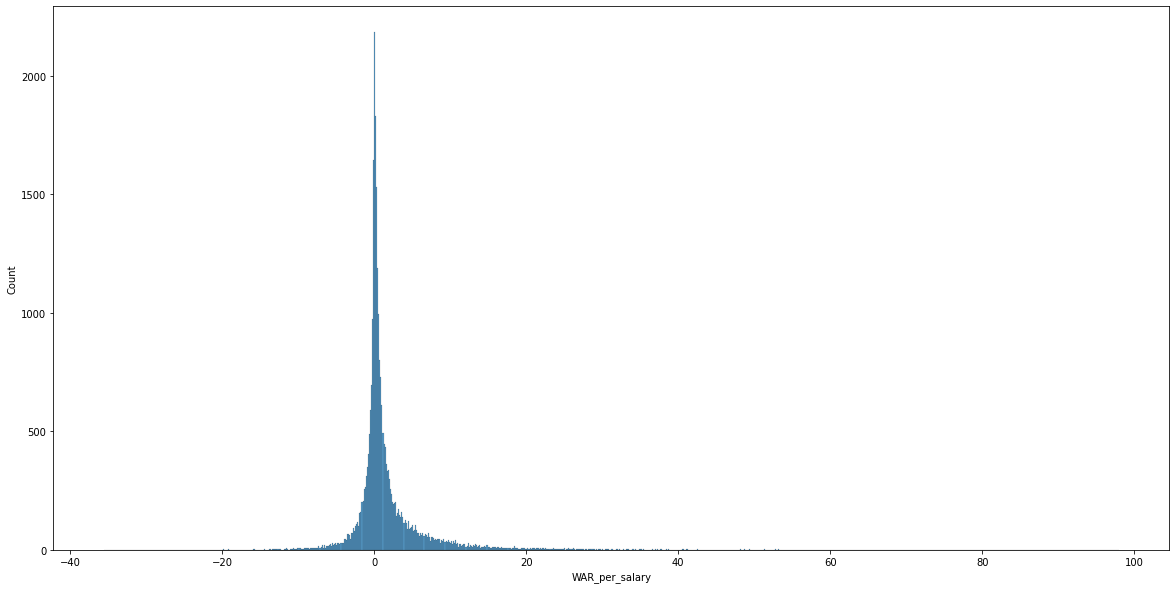

In [59]:
sns.histplot(player_stats_full[(player_stats_full['salary_x'] > 0) & (player_stats_full['WAR_per_salary'] > -1000)]['WAR_per_salary'])

In [63]:
player_stats_full[player_stats_full['WAR_per_salary'] > 50].sort_values('WAR_per_salary', ascending=False).head(5)

,index,name_common_x,age_x,mlb_ID_x,player_ID,year_ID,team_ID_x,stint_ID_x,lg_ID_x,PA,G_x,Inn,runs_bat,runs_br,runs_dp,runs_field,runs_infield,runs_outfield,runs_catcher,runs_good_plays,runs_defense,runs_position,runs_position_p,runs_replacement,runs_above_rep_x,runs_above_avg_x,runs_above_avg_off,runs_above_avg_def,WAA_x,WAA_off,WAA_def,WAR_x,WAR_def,WAR_off,WAR_rep_x,salary_x,pitcher,teamRpG_x,oppRpG_x,oppRpPA_rep,oppRpG_rep_x,pyth_exponent_x,pyth_exponent_rep_x,waa_win_perc_x,waa_win_perc_off,waa_win_perc_def,waa_win_perc_rep_x,OPS_plus,TOB_lg,TB_lg,teamID_x,franchID,name_common_y,age_y,mlb_ID_y,team_ID_y,stint_ID_y,lg_ID_y,G_y,GS,IPouts,IPouts_start,IPouts_relief,RA,xRA,xRA_sprp_adj,xRA_extras_adj,xRA_def_pitcher,PPF,PPF_custom,xRA_final,BIP,BIP_perc,RS_def_total,runs_above_avg_y,runs_above_avg_adj,runs_above_rep_y,RpO_replacement,GR_leverage_index_avg,WAR_y,salary_y,teamRpG_y,oppRpG_y,pyth_exponent_y,waa_win_perc_y,WAA_y,WAA_adj,oppRpG_rep_y,pyth_exponent_rep_y,waa_win_perc_rep_y,WAR_rep_y,ERA_plus,ER_lg,teamID_y,WAR_total,WAR_per_salary
8187,21025,Dion James,30.0,116476.0,jamesdi01,1993,NYY,1,AL,378.0,115,715.0,17.21,-2.11,1.68,-11.7,0.0,-1.0,0.0,NaN,-12.7,-2.98,0.0,14.18,15.3,1.1,13.8,-15.7,0.09,1.45,-1.60,1.44,-1.60,2.80,1.35,0.0,N,4.85279,4.73279,0.08114,4.60953,1.904,1.891,0.5009,0.5119,0.4864,0.4875,132.974581,125.616,137.989,NYY,NYY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.44,inf
39827,94139,Mark Eichhorn,25.0,113780.0,eichhma01,1986,TOR,1,AL,0.0,1,157.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,NaN,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,74000.0,Y,4.63756,4.63756,0.08322,4.63756,1.887,1.887,0.5000,0.5000,0.5000,0.5000,NaN,0.000,0.000,TOR,TOR,Mark Eichhorn,25.0,113780.0,TOR,1.0,AL,69.0,0.0,471.0,18.0,453.0,32.0,81.747,-6.205,NaN,1.005,101.0,100.641,75.015,393.0,0.0852,11.8,43.015,42.74,58.199,0.205,1.6696,7.25,74000.0,4.63756,4.01814,1.85,0.5659,4.5471,1.1898,4.86009,1.899,0.4778,1.5139,246.413333,73.924,TOR,7.25,97.972973
34836,84792,Kevin Seitzer,25.0,121983.0,seitzke01,1987,KCR,1,AL,725.0,161,1406.0,36.23,0.58,-0.67,-3.2,0.0,0.0,0.0,NaN,-3.2,0.73,0.0,23.55,57.2,33.7,36.9,-2.5,3.29,3.64,-0.19,5.49,-0.19,5.84,2.20,62500.0,N,5.16300,4.93400,0.08998,4.78768,1.933,1.912,0.5200,0.5219,0.4985,0.4856,128.173819,243.336,275.117,KCR,KCR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.49,87.840000
20002,44590,Chris Sabo,26.0,121606.0,saboch01,1988,CIN,1,NL,582.0,137,1176.0,6.21,0.95,-1.36,18.0,1.0,0.0,0.0,NaN,19.0,2.24,0.0,19.70,46.7,27.0,8.0,21.2,3.05,0.82,2.43,5.08,2.43,2.85,2.03,62500.0,N,3.91803,3.85934,0.06631,3.71552,1.794,1.781,0.5230,0.5068,0.5182,0.4831,104.771432,187.583,205.946,CIN,CIN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.08,81.280000
14122,32197,Devon White,24.0,124164.0,whitede03,1987,CAL,1,AL,696.0,159,1401.3,4.31,4.15,2.84,22.0,0.0,5.0,0.0,NaN,27.0,-4.18,0.0,23.26,57.4,34.1,7.1,22.8,3.42,0.79,2.31,5.59,2.31,2.96,2.17,70000.0,N,4.97878,4.93400,0.08998,4.78768,1.923,1.912,0.5211,0.5043,0.5142,0.4856,98.531009,224.651,268.252,CAL,ANA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.59,79.857143


In [105]:
player_stats_full.keys()

Index(['index', 'name_common_x', 'age_x', 'mlb_ID_x', 'player_ID', 'year_ID',
       'team_ID_x', 'stint_ID_x', 'lg_ID_x', 'PA', 'G_x', 'Inn', 'runs_bat',
       'runs_br', 'runs_dp', 'runs_field', 'runs_infield', 'runs_outfield',
       'runs_catcher', 'runs_good_plays', 'runs_defense', 'runs_position',
       'runs_position_p', 'runs_replacement', 'runs_above_rep_x',
       'runs_above_avg_x', 'runs_above_avg_off', 'runs_above_avg_def', 'WAA_x',
       'WAA_off', 'WAA_def', 'WAR_x', 'WAR_def', 'WAR_off', 'WAR_rep_x',
       'salary_x', 'pitcher', 'teamRpG_x', 'oppRpG_x', 'oppRpPA_rep',
       'oppRpG_rep_x', 'pyth_exponent_x', 'pyth_exponent_rep_x',
       'waa_win_perc_x', 'waa_win_perc_off', 'waa_win_perc_def',
       'waa_win_perc_rep_x', 'OPS_plus', 'TOB_lg', 'TB_lg', 'teamID_x',
       'franchID', 'name_common_y', 'age_y', 'mlb_ID_y', 'team_ID_y',
       'stint_ID_y', 'lg_ID_y', 'G_y', 'GS', 'IPouts', 'IPouts_start',
       'IPouts_relief', 'RA', 'xRA', 'xRA_sprp_adj', 'xRA_extr

### Graphs and Analysis

summary of data:

team_stats_full - stats grouped by team and year 

yearly_average - average salary grouped by year

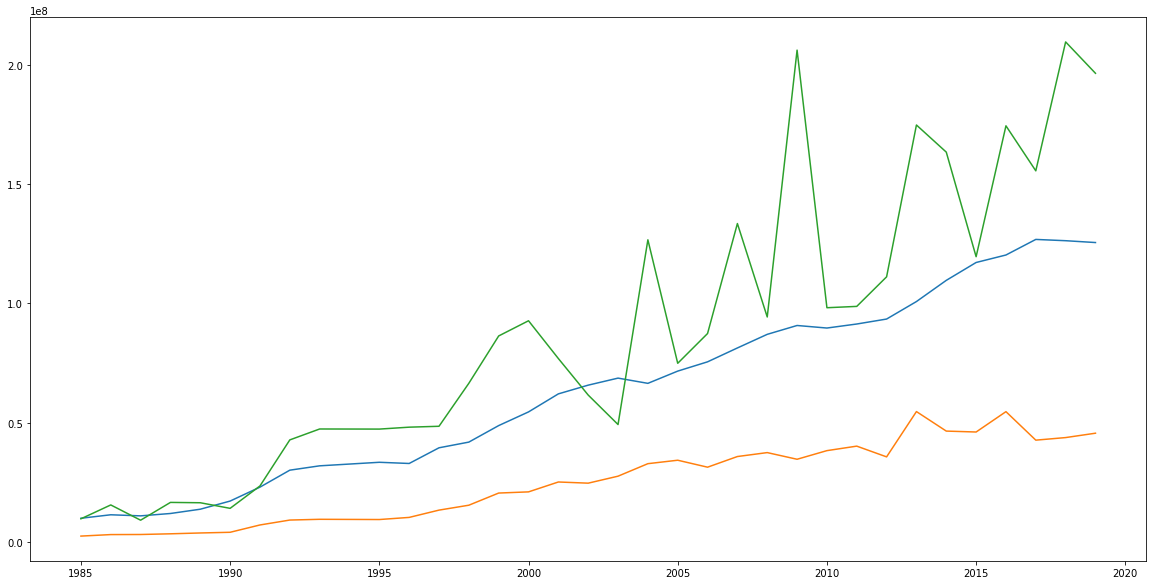

In [12]:
plt.plot(yearly_average['yearID'],yearly_average['salary'])
plt.plot(team_stats_full['yearID'].unique(),team_stats_full[team_stats_full['WSWin'] == 'Y']['salary'])


<AxesSubplot:xlabel='yearID', ylabel='salary'>

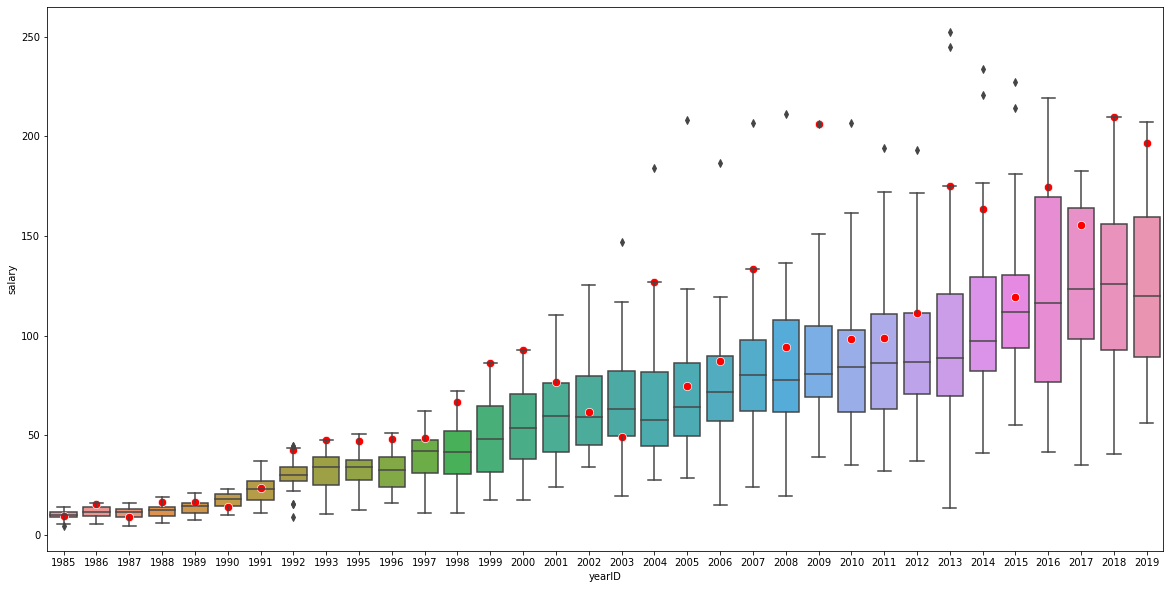

In [13]:
fig, ax = plt.subplots()
sns.boxplot(x = team_stats_full['yearID'],y = team_stats_full['salary']/1000000, ax=ax)
sns.scatterplot(x = team_stats_full['yearID'].unique().astype(str),y = team_stats_full[team_stats_full['WSWin'] == 'Y']['salary']/1000000, s = 70,color='red',ax=ax)
#ax.set_yscale('log')

In [14]:
team_stats_full[team_stats_full['playoffs'] == 'Y']['salary_plus']

10     0.976263
11     1.067544
22     1.205135
24     0.951417
26     1.241981
         ...   
968    1.640764
969    0.809319
975    1.217156
976    0.445809
979    1.565915
Name: salary_plus, Length: 252, dtype: float64

<AxesSubplot:xlabel='yearID', ylabel='salary_plus'>

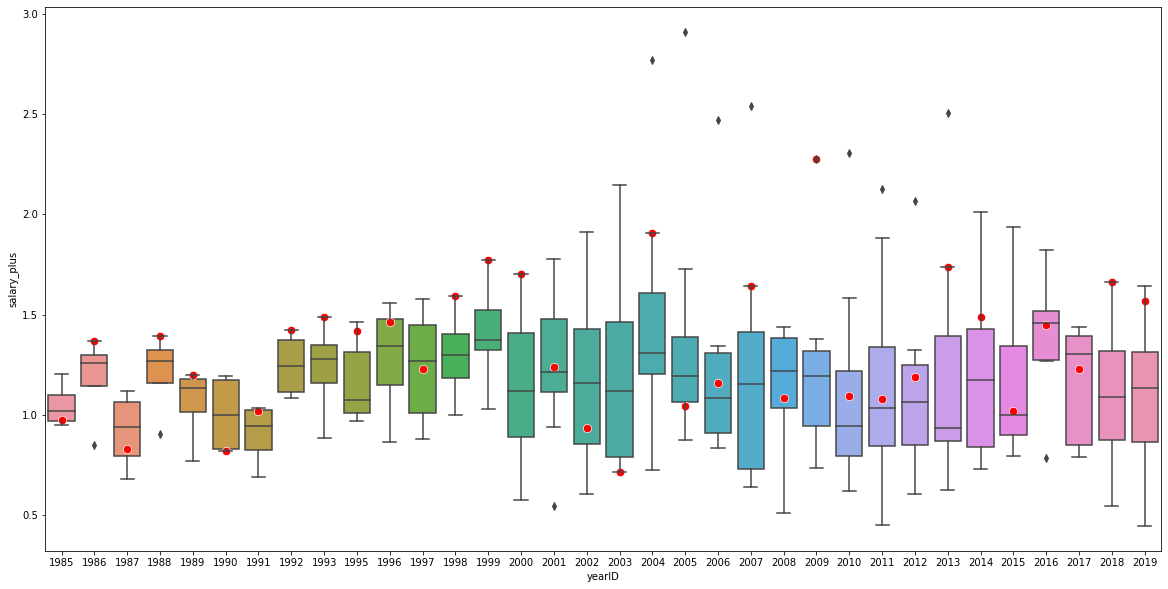

In [31]:
fig, ax = plt.subplots()
#sns.boxplot(x = team_stats_full['yearID'],y = team_stats_full[team_stats_full['playoffs'] == 'N']['salary']/1000000, ax=ax[0])
sns.boxplot(x = team_stats_full['yearID'],y = team_stats_full[team_stats_full['playoffs'] == 'Y']['salary_plus'], ax=ax)
sns.scatterplot(x = team_stats_full['yearID'].unique().astype(str),y = team_stats_full[team_stats_full['WSWin'] == 'Y']['salary_plus'], s = 70,color='red',ax=ax)
#ax.set_yscale('log')

<AxesSubplot:xlabel='salary_plus', ylabel='W'>

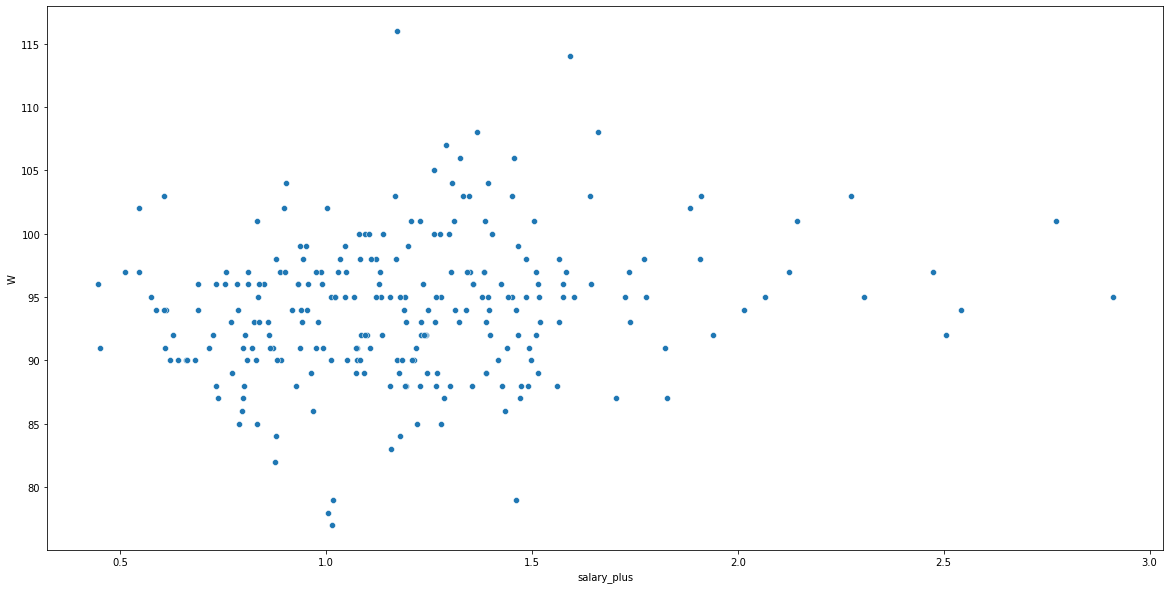

In [34]:
fig, ax = plt.subplots()
sns.scatterplot(x = team_stats_full[team_stats_full['playoffs'] == 'Y']['salary_plus'],y = team_stats_full[team_stats_full['playoffs'] == 'Y']['W'], ax=ax)

<AxesSubplot:xlabel='salary_plus', ylabel='W'>

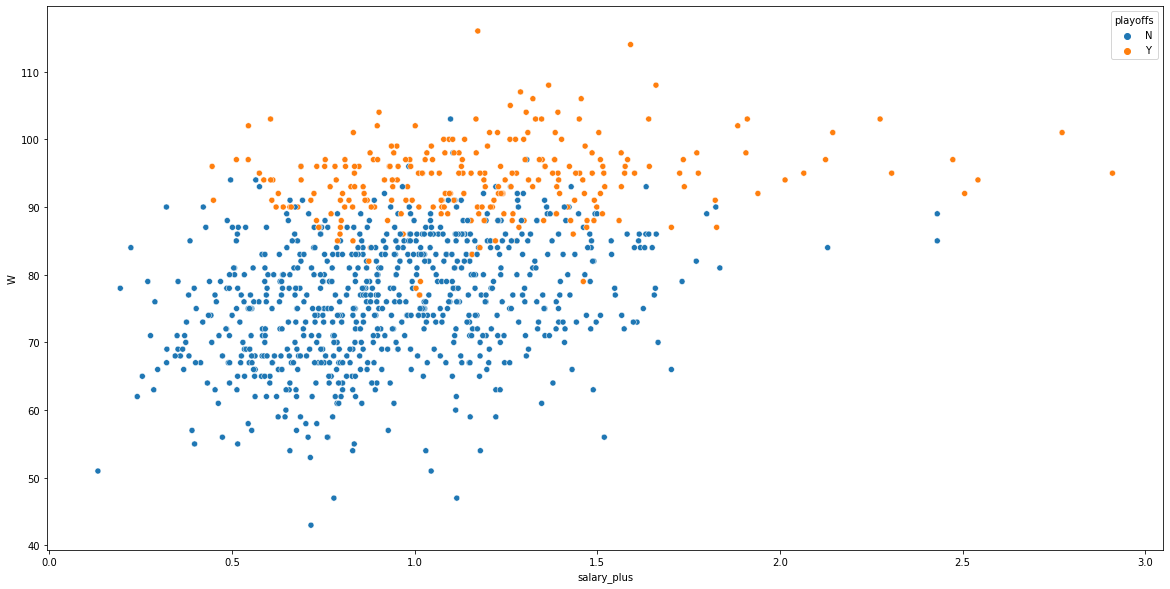

In [38]:
fig, ax = plt.subplots()
sns.scatterplot(x = team_stats_full['salary_plus'],y = team_stats_full['W'], hue = team_stats_full['playoffs'],ax=ax)

In [16]:
high_yearly_salary = team_stats_full.sort_values('salary',ascending=False).drop_duplicates(['yearID']).sort_values('yearID').reset_index()

<AxesSubplot:xlabel='yearID'>

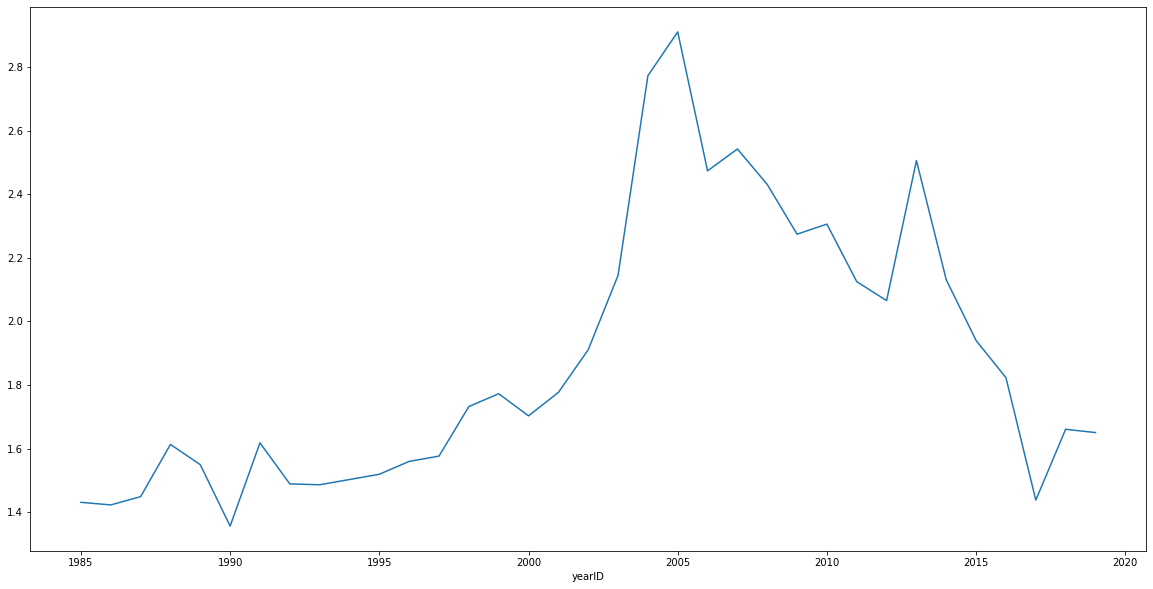

In [17]:
sns.lineplot(x=high_yearly_salary['yearID'],y=high_yearly_salary['salary']/yearly_average['salary']['mean'])

<AxesSubplot:>

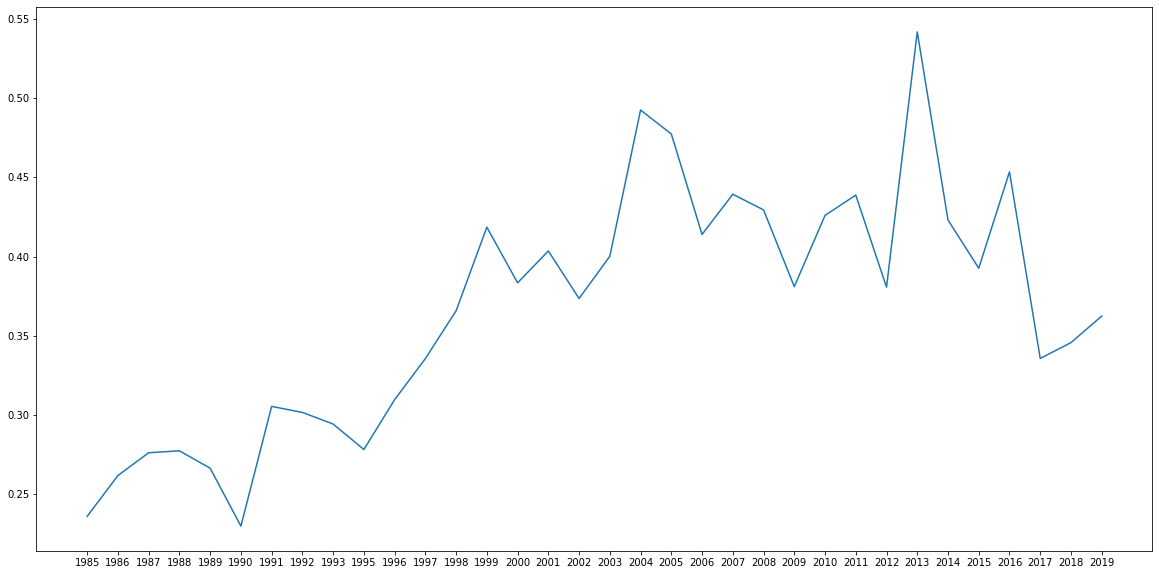

In [18]:
sns.lineplot(x = team_stats_full['yearID'].unique().astype(str),y = yearly_average['salary']['std']/yearly_average['salary']['mean'])

In [19]:
#sns.heatmap([team_stats_full[team_stats_full['yearID'] == 2013]['W'], team_stats_full[team_stats_full['yearID'] == 2013]['salary'], team_stats_full[team_stats_full['yearID'] == 2013]['WAR']])

Text(0, 0.5, 'WAR')

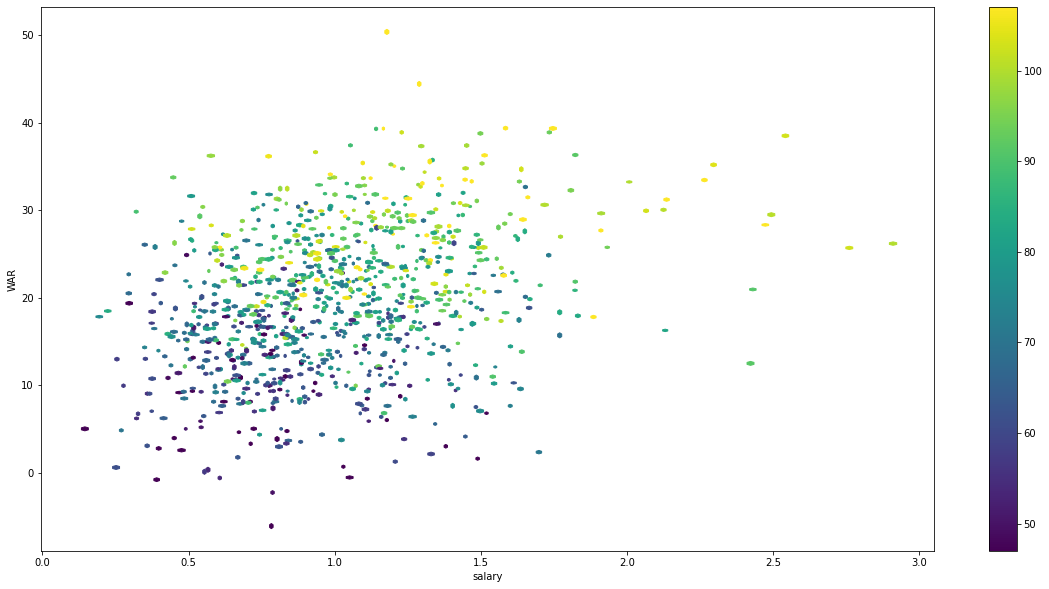

In [20]:
for i,year in enumerate(team_stats_full['yearID'].unique()):
    plt.hexbin(team_stats_full[team_stats_full['yearID'] == year]['salary']/yearly_average['salary']['mean'][i], team_stats_full[team_stats_full['yearID'] == year]['WAR'], C = team_stats_full[team_stats_full['yearID'] == year]['W'] )

plt.colorbar()
plt.xlabel('salary')
plt.ylabel('WAR')

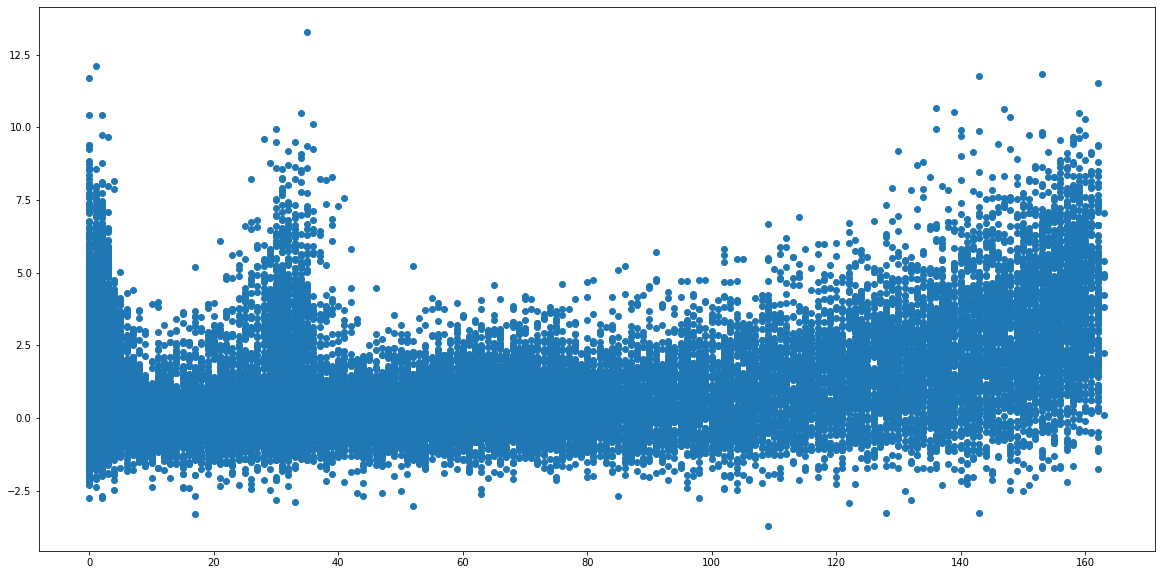

In [21]:
plt.scatter(player_stats_full['G_x'],player_stats_full['WAR_total'])

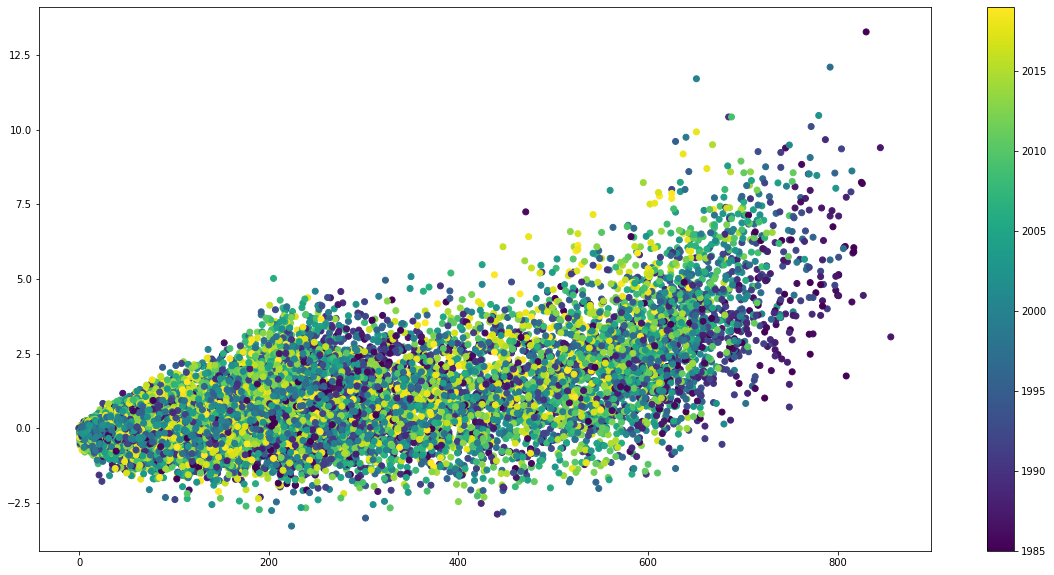

In [22]:
plt.scatter(player_stats_full[player_stats_full['pitcher'] == 'Y']['IPouts'],player_stats_full[player_stats_full['pitcher'] == 'Y']['WAR_total'], c = player_stats_full[player_stats_full['pitcher'] == 'Y']['year_ID'])
plt.colorbar()

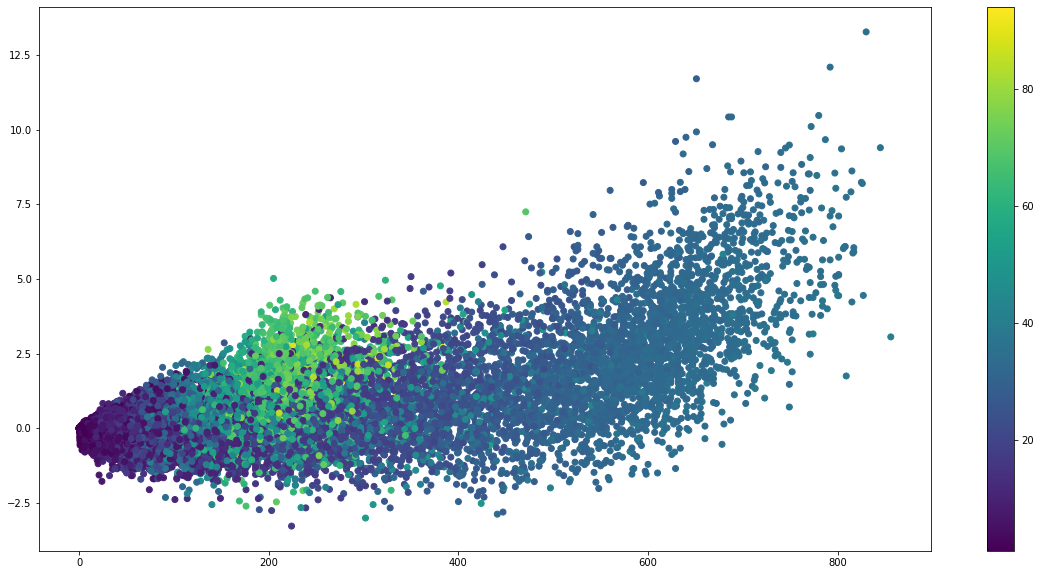

In [23]:
plt.scatter(player_stats_full[player_stats_full['pitcher'] == 'Y']['IPouts'],player_stats_full[player_stats_full['pitcher'] == 'Y']['WAR_total'], c = player_stats_full[player_stats_full['pitcher'] == 'Y']['G_y'])
plt.colorbar()

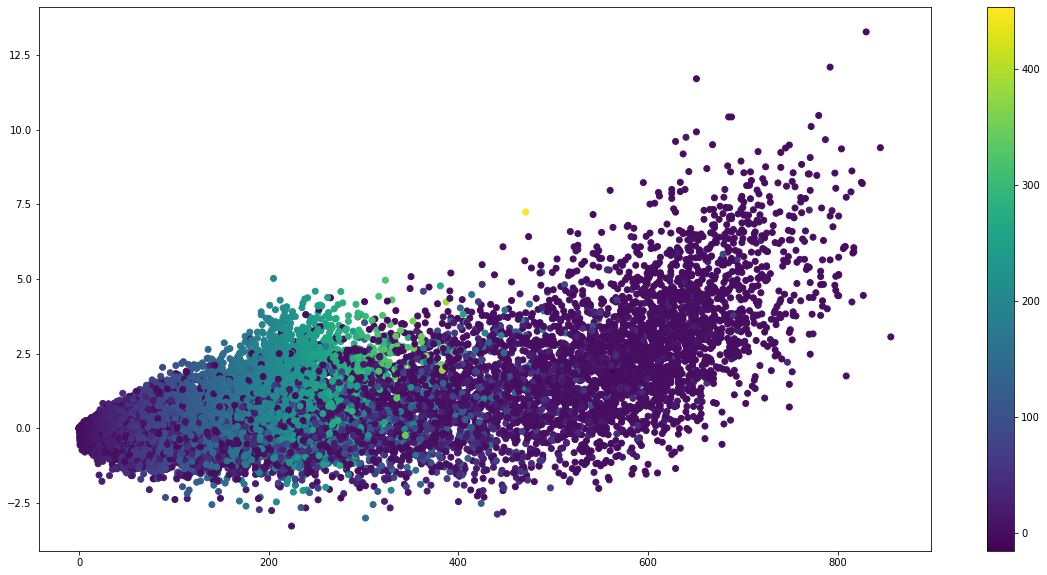

In [24]:
plt.scatter(player_stats_full[player_stats_full['pitcher'] == 'Y']['IPouts'],player_stats_full[player_stats_full['pitcher'] == 'Y']['WAR_total'], c = player_stats_full[player_stats_full['pitcher'] == 'Y']['IPouts_relief'])
plt.colorbar()

In [25]:
player_stats_full[player_stats_full['pitcher'] == 'Y'].sort_values('G_y',ascending=False)

,index,name_common_x,age_x,mlb_ID_x,player_ID,year_ID,team_ID_x,stint_ID_x,lg_ID_x,PA,G_x,Inn,runs_bat,runs_br,runs_dp,runs_field,runs_infield,runs_outfield,runs_catcher,runs_good_plays,runs_defense,runs_position,runs_position_p,runs_replacement,runs_above_rep_x,runs_above_avg_x,runs_above_avg_off,runs_above_avg_def,WAA_x,WAA_off,WAA_def,WAR_x,WAR_def,WAR_off,WAR_rep_x,salary_x,pitcher,teamRpG_x,oppRpG_x,oppRpPA_rep,oppRpG_rep_x,pyth_exponent_x,pyth_exponent_rep_x,waa_win_perc_x,waa_win_perc_off,waa_win_perc_def,waa_win_perc_rep_x,OPS_plus,TOB_lg,TB_lg,teamID_x,franchID,name_common_y,age_y,mlb_ID_y,team_ID_y,stint_ID_y,lg_ID_y,G_y,GS,IPouts,IPouts_start,IPouts_relief,RA,xRA,xRA_sprp_adj,xRA_extras_adj,xRA_def_pitcher,PPF,PPF_custom,xRA_final,BIP,BIP_perc,RS_def_total,runs_above_avg_y,runs_above_avg_adj,runs_above_rep_y,RpO_replacement,GR_leverage_index_avg,WAR_y,salary_y,teamRpG_y,oppRpG_y,pyth_exponent_y,waa_win_perc_y,WAA_y,WAA_adj,oppRpG_rep_y,pyth_exponent_rep_y,waa_win_perc_rep_y,WAR_rep_y,ERA_plus,ER_lg,teamID_y,WAR_total
26818,63255,Salomon Torres,34.0,123415.0,torresa01,2006,PIT,1,NL,5.0,91,93.3,-0.70,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.77,0.0,0.1,0.1,0.1,0.0,0.01,0.01,-0.03,0.01,-0.03,0.01,0.0,1525000.0,Y,4.86763,4.86675,0.09085,4.86504,1.913,1.913,0.5001,0.5001,0.5,0.4998,4.395666,1.702,2.191,PIT,PIT,Salomon Torres,34.0,123415.0,PIT,1.0,NL,94.0,0.0,280.0,0.0,280.0,42.0,50.145,-3.696,NaN,-2.724,99.0,99.445,48.900,295.0,0.0641,-42.5,6.900,7.296,15.461,0.211,1.5291,1.56,1525000.0,4.86675,4.78913,1.908,0.5077,0.7238,0.0208,4.95635,1.918,0.4913,0.8181,136.211765,46.312,PIT,1.57
9584,24353,Pedro Feliciano,33.0,408230.0,felicpe01,2010,NYM,1,NL,0.0,87,62.7,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,-0.04,0.00,-0.04,0.00,0.0,2900000.0,Y,4.38120,4.38120,0.08031,4.38120,1.856,1.856,0.5000,0.5000,0.5,0.5000,NaN,0.000,0.000,NYM,NYM,Pedro Feliciano,33.0,408230.0,NYM,1.0,NL,92.0,0.0,188.0,0.0,188.0,24.0,32.337,-2.422,NaN,1.126,97.0,97.729,28.135,188.0,0.0414,27.2,4.135,4.042,9.310,0.190,1.2653,0.88,2900000.0,4.38120,4.33727,1.854,0.5047,0.4324,-0.1053,4.43664,1.860,0.4942,0.5502,118.939130,27.356,NYM,0.88
25289,55877,Kent Tekulve,40.0,123175.0,tekulke01,1987,PHI,1,NL,3.0,90,105.0,1.15,-0.05,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.01,0.42,0.0,1.5,1.5,1.5,0.0,0.16,0.16,-0.01,0.16,-0.01,0.16,0.0,925000.0,Y,4.54050,4.52350,0.08069,4.52237,1.874,1.873,0.5018,0.5018,0.5,0.4999,45.985401,0.685,0.425,PHI,PHI,Kent Tekulve,40.0,123175.0,PHI,1.0,NL,90.0,0.0,315.0,0.0,315.0,38.0,53.673,-4.090,NaN,0.962,104.0,104.005,50.568,335.0,0.0723,13.3,12.568,11.655,22.473,0.200,1.2411,2.19,925000.0,4.52350,4.39400,1.866,0.5135,1.2150,-0.0418,4.63494,1.880,0.4886,1.0131,138.183333,49.746,PHI,2.35
39828,94140,Mark Eichhorn,26.0,113780.0,eichhma01,1987,TOR,1,AL,0.0,0,127.7,0.00,0.00,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,165500.0,Y,NaN,4.93400,0.08998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,0.000,TOR,TOR,Mark Eichhorn,26.0,113780.0,TOR,1.0,AL,89.0,0.0,383.0,0.0,383.0,47.0,70.541,-5.587,NaN,4.371,101.0,101.533,61.512,378.0,0.0876,49.9,14.512,14.402,27.649,0.218,1.3190,2.71,165500.0,4.93400,4.77218,1.911,0.5159,1.4151,0.0579,5.08281,1.928,0.4857,1.2400,142.755556,64.240,TOR,2.71
16863,37390,Paul Quantrill,34.0,120824.0,quantpa01,2003,LAD,1,NL,1.0,85,77.3,-0.28,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.14,0.0,-0.1,-0.1,-0.1,0.0,-0.02,-0.02,-0.04,-0.02,-0.04,-0.02,0.0,3333333.0,Y,4.62219,4.62384,0.08542,4.62347,1.885,1.885,0.4998,0.4998,0.5,0.5000,-100.000000,0.332,0.419,LAD,LAD,Paul Quantrill,34.0,120824.0,LAD,1.0,NL,89.0,0.0,232.0,0.0,232.0,18.0,40.495,-3.021,NaN,3.257,94.0,94.859,32.458,229.0,0.0552,59.0,14.458,14.090,21.197,0.201,1.3785,2.25,3333333.0,4.62384,4.46553,1.876,0.5163,1.4507,0.1189,4.69972,1.889,0.4923,0.6846,231.926667,34.789,LAD,2.23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [26]:
player_stats_full.keys()

Index(['index', 'name_common_x', 'age_x', 'mlb_ID_x', 'player_ID', 'year_ID',
       'team_ID_x', 'stint_ID_x', 'lg_ID_x', 'PA', 'G_x', 'Inn', 'runs_bat',
       'runs_br', 'runs_dp', 'runs_field', 'runs_infield', 'runs_outfield',
       'runs_catcher', 'runs_good_plays', 'runs_defense', 'runs_position',
       'runs_position_p', 'runs_replacement', 'runs_above_rep_x',
       'runs_above_avg_x', 'runs_above_avg_off', 'runs_above_avg_def', 'WAA_x',
       'WAA_off', 'WAA_def', 'WAR_x', 'WAR_def', 'WAR_off', 'WAR_rep_x',
       'salary_x', 'pitcher', 'teamRpG_x', 'oppRpG_x', 'oppRpPA_rep',
       'oppRpG_rep_x', 'pyth_exponent_x', 'pyth_exponent_rep_x',
       'waa_win_perc_x', 'waa_win_perc_off', 'waa_win_perc_def',
       'waa_win_perc_rep_x', 'OPS_plus', 'TOB_lg', 'TB_lg', 'teamID_x',
       'franchID', 'name_common_y', 'age_y', 'mlb_ID_y', 'team_ID_y',
       'stint_ID_y', 'lg_ID_y', 'G_y', 'GS', 'IPouts', 'IPouts_start',
       'IPouts_relief', 'RA', 'xRA', 'xRA_sprp_adj', 'xRA_extr

In [27]:
player_stats_full[player_stats_full['IPouts_relief'] > 400]

,index,name_common_x,age_x,mlb_ID_x,player_ID,year_ID,team_ID_x,stint_ID_x,lg_ID_x,PA,G_x,Inn,runs_bat,runs_br,runs_dp,runs_field,runs_infield,runs_outfield,runs_catcher,runs_good_plays,runs_defense,runs_position,runs_position_p,runs_replacement,runs_above_rep_x,runs_above_avg_x,runs_above_avg_off,runs_above_avg_def,WAA_x,WAA_off,WAA_def,WAR_x,WAR_def,WAR_off,WAR_rep_x,salary_x,pitcher,teamRpG_x,oppRpG_x,oppRpPA_rep,oppRpG_rep_x,pyth_exponent_x,pyth_exponent_rep_x,waa_win_perc_x,waa_win_perc_off,waa_win_perc_def,waa_win_perc_rep_x,OPS_plus,TOB_lg,TB_lg,teamID_x,franchID,name_common_y,age_y,mlb_ID_y,team_ID_y,stint_ID_y,lg_ID_y,G_y,GS,IPouts,IPouts_start,IPouts_relief,RA,xRA,xRA_sprp_adj,xRA_extras_adj,xRA_def_pitcher,PPF,PPF_custom,xRA_final,BIP,BIP_perc,RS_def_total,runs_above_avg_y,runs_above_avg_adj,runs_above_rep_y,RpO_replacement,GR_leverage_index_avg,WAR_y,salary_y,teamRpG_y,oppRpG_y,pyth_exponent_y,waa_win_perc_y,WAA_y,WAA_adj,oppRpG_rep_y,pyth_exponent_rep_y,waa_win_perc_rep_y,WAR_rep_y,ERA_plus,ER_lg,teamID_y,WAR_total
39827,94139,Mark Eichhorn,25.0,113780.0,eichhma01,1986,TOR,1,AL,0.0,1,157.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,74000.0,Y,4.63756,4.63756,0.08322,4.63756,1.887,1.887,0.5,0.5,0.5,0.5,NaN,0.0,0.0,TOR,TOR,Mark Eichhorn,25.0,113780.0,TOR,1.0,AL,69.0,0.0,471.0,18.0,453.0,32.0,81.747,-6.205,NaN,1.005,101.0,100.641,75.015,393.0,0.0852,11.8,43.015,42.74,58.199,0.205,1.6696,7.25,74000.0,4.63756,4.01814,1.85,0.5659,4.5471,1.1898,4.86009,1.899,0.4778,1.5139,246.413333,73.924,TOR,7.25
